## Logistic Regression and ROC analysis

1) run logistic regression on the training dataset to determine a cutoff point (no CV or anything)
2) run an ROC analysis on the holdout group using that cutoff

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=verbose)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [36]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
    "classifier__penalty": ['l1','l2']
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),
    ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_data = _data[['GroupID','UPDRS']]

## 1. Control vs. PD/MSA/PSP

In [37]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 4832.930238571752, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.284 (+/-0.004) for {'classifier__C': 1e-05, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 1e-05, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l1'}
0.861 (+/-0.082) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l1'}
0.864 (+/-0.075) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l2'}
0.863 (+/-0.075) for {'classifier__C': 0.01438449888287663, 'classifier__penalty': 'l1'}
0.883 (+/-0.064) for {'classifier__C': 0.01438449888287663, 'classifier_

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.1s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0038008689880371094	0.0011655263949726417
score_time	0.0067975521087646484	0.0011663433770516976
test_recall	0.9234782608695653	0.0370561317437609
train_recall	0.9217391304347826	0.009223131928520195
test_precision	0.9835298040691475	0.0064866955195602505
train_precision	0.9828431240293887	0.0011746313498847143
test_auc	0.9420289855072463	0.01467120409976585
train_auc	0.9405849318180038	0.0051428203942829225
test_specificity	0.9605797101449276	0.01622095330137146
train_specificity	0.959430733201225	0.002669416695991214
test_npv	0.8385145547580735	0.06588556346141405
train_npv	0.8297281546303784	0.017035827620801452
test_accuracy	0.9339984472049689	0.023787385625641477
train_accuracy	0.9324428424005466	0.006846414457086683


C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

In [39]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	6.132640231629477


              precision    recall  f1-score   support

           0       0.92      0.94      0.93        50
           1       0.98      0.97      0.98       151

   micro avg       0.97      0.97      0.97       201
   macro avg       0.95      0.96      0.95       201
weighted avg       0.97      0.97      0.97       201



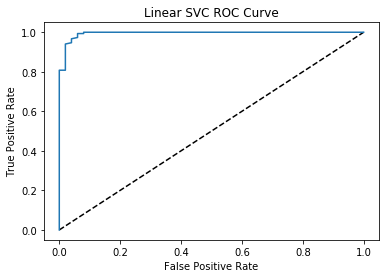

0.0 0.0
0.0 0.013245033112582781
0.0 0.059602649006622516
0.0 0.0728476821192053
0.0 0.09271523178807947
0.0 0.10596026490066225
0.0 0.11258278145695365
0.0 0.13245033112582782
0.0 0.1390728476821192
0.0 0.16556291390728478
0.0 0.18543046357615894
0.0 0.1986754966887417
0.0 0.2781456953642384
0.0 0.2913907284768212
0.0 0.304635761589404
0.0 0.31788079470198677
0.0 0.32450331125827814
0.0 0.36423841059602646
0.0 0.39072847682119205
0.0 0.4105960264900662
0.0 0.423841059602649
0.0 0.4304635761589404
0.0 0.45695364238410596
0.0 0.46357615894039733
0.0 0.4900662251655629
0.0 0.5033112582781457
0.0 0.5165562913907285
0.0 0.5364238410596026
0.0 0.5629139072847682
0.0 0.5695364238410596
0.0 0.6026490066225165
0.0 0.609271523178808
0.0 0.6357615894039735
0.0 0.6423841059602649
0.0 0.6688741721854304
0.0 0.6887417218543046
0.0 0.7019867549668874
0.0 0.7152317880794702
0.0 0.7350993377483444
0.0 0.7417218543046358
0.0 0.7615894039735099
0.0 0.7880794701986755
0.0 0.7947019867549668
0.0 0.8079470

In [40]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [41]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l2'}

Grid scores on development set:

0.702 (+/-0.005) for {'classifier__C': 1e-05, 'classifier__penalty': 'l1'}
0.702 (+/-0.042) for {'classifier__C': 1e-05, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l1'}
0.710 (+/-0.048) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l1'}
0.703 (+/-0.050) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l1'}
0.717 (+/-0.046) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l2'}
0.702 (+/-0.042) for {'classifier__C': 0.01438449888287663, 'classifier__penalty': 'l1'}
0.702 (+/-0.042) for {'classifier__C': 0.01438449888287663, 'classifi

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0036031246185302735	0.0008024284724289332
score_time	0.005999898910522461	0.0010945389201388446
test_recall	0.6238655462184874	0.057099835510355496
train_recall	0.6329475549994787	0.006980142408580216
test_precision	0.5008286893704851	0.0340008444773843
train_precision	0.5156367826567464	0.014781697827885538
test_auc	0.6780273229436309	0.020756371847564677
train_auc	0.6899376755648644	0.008356557224895589
test_specificity	0.7321890996687743	0.049964478855494945
train_specificity	0.7469277961302502	0.013837840784971975
test_npv	0.8215924160227959	0.016877444128551685
train_npv	0.8271744456171731	0.004093537176481489
test_accuracy	0.7000272940452851	0.026052205120243626
train_accuracy	0.7129253306009158	0.010304651254894855


C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

In [43]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.2671565074565281


              precision    recall  f1-score   support

           0       0.82      0.70      0.76       107
           1       0.42      0.59      0.49        39

   micro avg       0.67      0.67      0.67       146
   macro avg       0.62      0.65      0.62       146
weighted avg       0.72      0.67      0.69       146



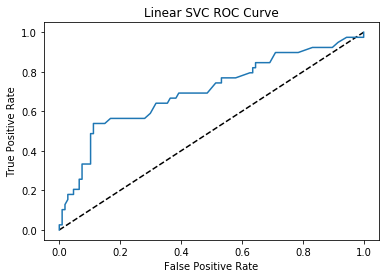

0.0 0.0
0.0 0.02564102564102564
0.009345794392523364 0.02564102564102564
0.009345794392523364 0.10256410256410256
0.018691588785046728 0.10256410256410256
0.018691588785046728 0.1282051282051282
0.028037383177570093 0.15384615384615385
0.028037383177570093 0.1794871794871795
0.04672897196261682 0.1794871794871795
0.04672897196261682 0.20512820512820512
0.06542056074766354 0.20512820512820512
0.06542056074766354 0.2564102564102564
0.07476635514018691 0.2564102564102564
0.07476635514018691 0.28205128205128205
0.07476635514018691 0.3333333333333333
0.102803738317757 0.3333333333333333
0.102803738317757 0.38461538461538464
0.102803738317757 0.4358974358974359
0.102803738317757 0.48717948717948717
0.11214953271028037 0.48717948717948717
0.11214953271028037 0.5384615384615384
0.12149532710280374 0.5384615384615384
0.14018691588785046 0.5384615384615384
0.14953271028037382 0.5384615384615384
0.16822429906542055 0.5641025641025641
0.22429906542056074 0.5641025641025641
0.2336448598130841 0.564

In [44]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [45]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 1e-05, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.878 (+/-0.006) for {'classifier__C': 1e-05, 'classifier__penalty': 'l1'}
0.762 (+/-0.051) for {'classifier__C': 1e-05, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l1'}
0.760 (+/-0.051) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l1'}
0.762 (+/-0.051) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l1'}
0.760 (+/-0.054) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l2'}
0.764 (+/-0.053) for {'classifier__C': 0.01438449888287663, 'classifier__penalty': 'l1'}
0.760 (+/-0.054) for {'classifier__C': 0.01438449888287663, 'classifier__penalty': '

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.003600597381591797	0.0011998420808660897
score_time	0.006400966644287109	0.0014962076084164948
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	1.0	0.0
train_specificity	1.0	0.0
test_npv	0.8775973551685696	0.002929575579236404
train_npv	0.8775869096212014	0.0007385054107702998
test_accuracy	0.8775973551685696	0.002929575579236404
train_accuracy	0.8775869096212014	0.0007385054107702998


C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Pre

In [47]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.0


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       134
           1       0.00      0.00      0.00        12

   micro avg       0.92      0.92      0.92       146
   macro avg       0.46      0.50      0.48       146
weighted avg       0.84      0.92      0.88       146



C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


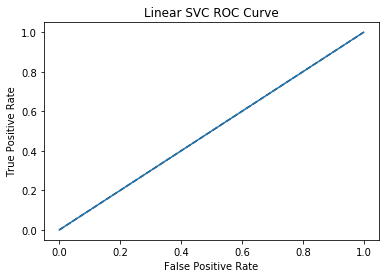

0.0 0.0
1.0 1.0


In [48]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [49]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters set found on development set:

{'classifier__C': 1e-05, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.824 (+/-0.006) for {'classifier__C': 1e-05, 'classifier__penalty': 'l1'}
0.622 (+/-0.100) for {'classifier__C': 1e-05, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l1'}
0.628 (+/-0.107) for {'classifier__C': 6.158482110660267e-05, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l1'}
0.619 (+/-0.108) for {'classifier__C': 0.000379269019073225, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l1'}
0.633 (+/-0.098) for {'classifier__C': 0.002335721469090121, 'classifier__penalty': 'l2'}
0.686 (+/-0.227) for {'classifier__C': 0.01438449888287663, 'classifier

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.003599262237548828	0.0016236040880625092
score_time	0.00659942626953125	0.0011972392480831904
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	1.0	0.0
train_specificity	1.0	0.0
test_npv	0.8241571521931341	0.0030255251591983444
train_npv	0.8241391362773293	0.0007597611984805219
test_accuracy	0.8241571521931341	0.0030255251591983444
train_accuracy	0.8241391362773293	0.0007597611984805219


C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Pre

In [51]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.0


C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       119
           1       0.00      0.00      0.00        27

   micro avg       0.82      0.82      0.82       146
   macro avg       0.41      0.50      0.45       146
weighted avg       0.66      0.82      0.73       146



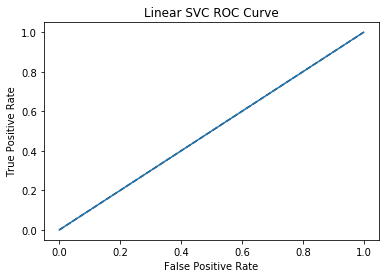

0.0 0.0
1.0 1.0


In [52]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)